<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version**



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [ ]:
# ## install finrl library
!pip install wrds
!pip install swig
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install -e ~/Workspace/AI4Finance/FinRL

In [31]:
!pip install -e ~/Workspace/AI4Finance/FinRL

Obtaining file:///Users/tonyren/Workspace/AI4Finance/FinRL
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /private/var/folders/fk/ghrbpzjd2ljb898y6fvw8sgc0000gn/T/pip-install-gsq68dgo/elegantrl_fb09cc4786fe4a2cb3a07821e4446688
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /private/var/folders/fk/ghrbpzjd2ljb898y6fvw8sgc0000gn/T/pip-install-gsq68dgo/elegantrl_fb09cc4786fe4a2cb3a07821e4446688
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit c2939fefe0e3ec55601ded49e39fdf9d7d781ea0
  Preparing metadata (setup.py) ... done
  Building editable for finrl (pyproject.toml) ... done
  Created wheel for finrl: filename=finrl-0.3.6-py3-none-any.whl size=9103 sha256=ebb9a360ce7d0d9eb

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import CUSTOM_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finrl.agents.stablebaselines3.models import hyperparameterized_model_name, MODELS


from pprint import pprint

import sys
import itertools

In [3]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [4]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import CUSTOM_TICKER
from finrl.meta.preprocessor.preprocessors import FeatureEngineer

TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2022-11-10'
TEST_START_DATE = '2022-11-11'
TEST_END_DATE = '2024-11-11'

INDICATORS = ['close_7_s']

In [5]:
CUSTOM_TICKER = [
    "INTC"
]

In [6]:
def dummy_stock(n, type='flat'):
    if type == 'flat':
        return [10]*n
    if type == 'triangle':
       return (list(np.arange(100,2000,100)) + list(np.arange(2000,100,-100))*n)[0:n]
    if type == 'up':
       return list(np.arange(10,20000,(20000-10)/n))[0:n]
    if type == 'down':
       return list(np.arange(20000,10,(10-20000)/n))[0:n]

In [14]:
(list(np.arange(100,2000,100)) + list(np.arange(2000,100,-100)))*2

[100,
 200,
 300,
 400,
 500,
 600,
 700,
 800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2000,
 1900,
 1800,
 1700,
 1600,
 1500,
 1400,
 1300,
 1200,
 1100,
 1000,
 900,
 800,
 700,
 600,
 500,
 400,
 300,
 200,
 100,
 200,
 300,
 400,
 500,
 600,
 700,
 800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2000,
 1900,
 1800,
 1700,
 1600,
 1500,
 1400,
 1300,
 1200,
 1100,
 1000,
 900,
 800,
 700,
 600,
 500,
 400,
 300,
 200]

In [7]:
if True:
    df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = CUSTOM_TICKER).fetch_data()

    #df['close'] = dummy_stock(df.shape[0], type='up')
    #df['open'] = dummy_stock(df.shape[0], type='up')
    #df['low'] = dummy_stock(df.shape[0], type='up')
    #df['high'] = dummy_stock(df.shape[0], type='up')
    fe = FeatureEngineer(use_technical_indicator=True,
                         tech_indicator_list = INDICATORS,
                         use_turbulence=True,
                         user_defined_feature = False)

    processed = fe.preprocess_data(df)
    processed = processed.copy()
    processed = processed.fillna(0)
    processed = processed.replace(np.inf,0)
    processed['close_7_s'] = 100*(processed['close_7_s']-processed['close'])/processed['close']


    processed.to_csv("datasets/processed_sanity.csv", index=False)

[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3739, 8)
Successfully added technical indicators
Successfully added turbulence index


In [8]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 1, State Space: 4


In [9]:
import random
import copy
def generate_hyperparams_list_from_code(num_variations=5, duplication=4):
    hyperparams_list = []

    # PPO Variations
    PPO_variations = {
        'learning_rate': [1e-5, 1e-4, 1e-3],
        'n_steps': [512, 1024, 2048],
        'batch_size': [64, 128],
        'gamma': [0.98, 0.99],
        'ent_coef': [1e-5, 1e-3],
        'clip_range': [0.2, 0.3],
        'gae_lambda': [0.95, 0.98]
    }

    # A2C Variations
    A2C_variations = {
        'learning_rate': [1e-5, 1e-4, 1e-3, 0.0007],
        'n_steps': [5, 10, 20],
        'gamma': [0.98, 0.99],
        'ent_coef': [1e-5, 1e-3, 0.005],
        'normalize_advantage': [True, False],
        'use_rms_prop': [True, False]
    }

    # DDPG Variations
    DDPG_variations = {
        'learning_rate': [1e-5, 1e-4, 1e-3],
        'batch_size': [64, 128],
        'buffer_size': [int(1e5), int(1e6)],
        'tau': [0.005, 0.01],
        'gamma': [0.98, 0.99],
        'train_freq': [1, 10],
        'action_noise': ['normal', 'ornstein_uhlenbeck']
    }

    # SAC Variations
    SAC_variations = {
        'learning_rate': [1e-5, 1e-4, 1e-3],
        'batch_size': [64, 128],
        'buffer_size': [int(1e5), int(1e6)],
        'tau': [0.005, 0.01],
        'gamma': [0.98, 0.99],
        'train_freq': [1, 10],
        'ent_coef': ['auto'],
    }

    # TD3 Variations
    TD3_variations = {
        'learning_rate': [1e-5, 1e-4, 1e-3],
        'batch_size': [64, 128],
        'buffer_size': [int(1e5), int(1e6)],
        'tau': [0.005, 0.01],
        'gamma': [0.98, 0.99],
        'train_freq': [1, 10],
        'action_noise': ['normal', 'ornstein_uhlenbeck']
    }

    # Timesteps Variations
    timesteps_variations = {
        'a2c': [10000],
        'ppo': [10000],
        'ddpg': [10000],
        'sac': [10000],
        'td3': [10000]
    }

    hyperparams_list = []
    for i in range(num_variations):
        A2C_kwargs = {k: random.choice(v) for k, v in A2C_variations.items()}
        PPO_kwargs = {k: random.choice(v) for k, v in PPO_variations.items()}
        DDPG_kwargs = {k: random.choice(v) for k, v in DDPG_variations.items()}
        SAC_kwargs = {k: random.choice(v) for k, v in SAC_variations.items()}
        TD3_kwargs = {k: random.choice(v) for k, v in TD3_variations.items()}
        timesteps_dict = {k: random.choice(v) for k, v in timesteps_variations.items()}

        # Assign a unique name to each set
        for j in range(duplication):
            name = f"variant_{j+1}"
            print(name)

            A2C_kwargs['name'] = name
            PPO_kwargs['name'] = name
            DDPG_kwargs['name'] = name
            SAC_kwargs['name'] = name
            TD3_kwargs['name'] = name

            hyperparam = {
                'A2C_model_kwargs': A2C_kwargs,
                'PPO_model_kwargs': PPO_kwargs,
                'DDPG_model_kwargs': DDPG_kwargs,
                'SAC_model_kwargs': SAC_kwargs,
                'TD3_model_kwargs': TD3_kwargs,
                'timesteps_dict': timesteps_dict
            }

            hyperparams_list.append(copy.deepcopy(hyperparam))

    return hyperparams_list

In [10]:
hyperparams_list = generate_hyperparams_list_from_code(num_variations=5, duplication=10)

variant_1
variant_2
variant_3
variant_4
variant_5
variant_6
variant_7
variant_8
variant_9
variant_10
variant_1
variant_2
variant_3
variant_4
variant_5
variant_6
variant_7
variant_8
variant_9
variant_10
variant_1
variant_2
variant_3
variant_4
variant_5
variant_6
variant_7
variant_8
variant_9
variant_10
variant_1
variant_2
variant_3
variant_4
variant_5
variant_6
variant_7
variant_8
variant_9
variant_10
variant_1
variant_2
variant_3
variant_4
variant_5
variant_6
variant_7
variant_8
variant_9
variant_10


In [11]:
import ray
import random
import numpy as np
import torch

ray.init(ignore_reinit_error=True)

@ray.remote
def run_ensemble_with_params(hyperparams, seed, processed):

    #np.random.seed(seed)
    #random.seed(seed)
    #torch.manual_seed(seed)
    rebalance_window = 100
    validation_window = 310

    A2C_model_kwargs = hyperparams['A2C_model_kwargs']
    PPO_model_kwargs = hyperparams['PPO_model_kwargs']
    DDPG_model_kwargs = hyperparams['DDPG_model_kwargs']
    SAC_model_kwargs = hyperparams['SAC_model_kwargs']
    TD3_model_kwargs = hyperparams['TD3_model_kwargs']
    timesteps_dict = hyperparams['timesteps_dict']

    env_kwargs = {
        "hmax": 1000,
        "initial_amount": 1000000,
        "buy_cost_pct": 0.001,
        "sell_cost_pct": 0.001,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1,
        "print_verbosity":100,
    }

    # Instantiate and run the ensemble agent
    ensemble_agent = DRLEnsembleAgent(
        df=processed,
        train_period=(TRAIN_START_DATE, TRAIN_END_DATE),
        val_test_period=(TEST_START_DATE, TEST_END_DATE),
        rebalance_window=rebalance_window,
        validation_window=validation_window,
        **env_kwargs
    )

    df_summary = ensemble_agent.run_ensemble_strategy(
        A2C_model_kwargs,
        PPO_model_kwargs,
        DDPG_model_kwargs,
        SAC_model_kwargs,
        TD3_model_kwargs,
        timesteps_dict
    )

    return df_summary

2024-11-29 18:10:37,729	INFO worker.py:1807 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


In [82]:
ray.shutdown()


In [12]:
seeds = [42]
futures = []

for seed in seeds:
    for hyperparams in hyperparams_list:
        future = run_ensemble_with_params.remote(
            hyperparams,
            seed,
            processed
        )
        futures.append(future)

results = ray.get(futures)
for df_summary in results:
    print(df_summary)

  Iter   Val Start     Val End Model Used A2C Sharpe PPO Sharpe DDPG Sharpe  \
0  410  2022-11-14  2024-02-09        PPO   0.024125   0.134721    0.133302   

  SAC Sharpe TD3 Sharpe  
0        0.0        0.0  
  Iter   Val Start     Val End Model Used A2C Sharpe PPO Sharpe DDPG Sharpe  \
0  410  2022-11-14  2024-02-09        SAC   0.043531   0.087926         0.0   

  SAC Sharpe TD3 Sharpe  
0   0.133302        0.0  
  Iter   Val Start     Val End Model Used A2C Sharpe PPO Sharpe DDPG Sharpe  \
0  410  2022-11-14  2024-02-09        TD3   0.110125   0.033671         0.0   

  SAC Sharpe TD3 Sharpe  
0   0.133302   0.133302  
  Iter   Val Start     Val End Model Used A2C Sharpe PPO Sharpe DDPG Sharpe  \
0  410  2022-11-14  2024-02-09       DDPG   0.101471   0.114439    0.133302   

  SAC Sharpe TD3 Sharpe  
0        0.0        0.0  
  Iter   Val Start     Val End Model Used A2C Sharpe PPO Sharpe DDPG Sharpe  \
0  410  2022-11-14  2024-02-09        SAC   0.029186   0.052189         0.0  

In [15]:
run_reports = []
for hyperparam in hyperparams_list:
    for k, v in hyperparam.items():
        if 'model_kwargs' in k:
            model_name = k.split('_')[0].lower()
            run_reports.append([hyperparameterized_model_name(model_name, v),
                        model_name, v])

performance_stats = pd.DataFrame(run_reports, columns=['hash_id', 'model_name', 'config'])

In [16]:
performance_stats

,hash_id,model_name,config
0,069f86e304c5e322018de9d1b155c769,a2c,"{'learning_rate': 1e-05, 'n_steps': 10, 'gamma..."
1,764d0976ac29f04eb19b90e27e18bddd,ppo,"{'learning_rate': 1e-05, 'n_steps': 2048, 'bat..."
2,71ca06de729ef73064945daa090ba7cc,ddpg,"{'learning_rate': 0.0001, 'batch_size': 128, '..."
3,8d1df26cce39ffb0c4e792f2456d00ac,sac,"{'learning_rate': 0.0001, 'batch_size': 128, '..."
4,0ac3fefc4465dea92cfe9ea549890d45,td3,"{'learning_rate': 1e-05, 'batch_size': 64, 'bu..."
...,...,...,...
245,92fedb5e6877bce69737e7e0a7fa3270,a2c,"{'learning_rate': 0.0007, 'n_steps': 20, 'gamm..."
246,f270b6e6014b248e7aade2f1f00c5198,ppo,"{'learning_rate': 0.0001, 'n_steps': 2048, 'ba..."
247,e2796f21b37e2d33159892ac666fa3f5,ddpg,"{'learning_rate': 0.001, 'batch_size': 64, 'bu..."
248,76f4cad41f59db7480b772b2b4661411,sac,"{'learning_rate': 1e-05, 'batch_size': 64, 'bu..."


In [17]:
portfolio_return = []
for i, row in performance_stats.iterrows():
    r = (list(pd.read_csv(f'results/account_value_validation_{row["hash_id"]}_410.csv')['account_value'])[-1]/1000000) - 1
    portfolio_return.append(r)

performance_stats['r'] = portfolio_return


In [18]:
import hashlib
performance_stats['config_str'] = [hashlib.md5(str({z for z in x.items() if z[0] != 'name'}).encode()).hexdigest()  for x in performance_stats['config']]

In [19]:
performance_stats.sort_values(['r'])

,hash_id,model_name,config,r,config_str
50,cf4073efc79463b045a17286181c3afe,a2c,"{'learning_rate': 1e-05, 'n_steps': 5, 'gamma'...",-0.012347,4fd6ccc389f1fe7b023d3ca2bc7019a6
156,00d066119e5ab684de8e52980c53b237,ppo,"{'learning_rate': 0.001, 'n_steps': 512, 'batc...",-0.009493,7012cc6ce0bbcfead8a5be3589ef3720
111,6e5c5e02bde7e56536d6c462a659b9f4,ppo,"{'learning_rate': 0.0001, 'n_steps': 1024, 'ba...",-0.009115,378269c0d7355133aeece6104c50cfee
120,eb0bf96569cd5cfdfb5a9548732f1b20,a2c,"{'learning_rate': 1e-05, 'n_steps': 20, 'gamma...",-0.008313,3ed981268ee48f92a656c9537ec0ef9c
196,85c4c5724affdf4cd09dc7fa641ed983,ppo,"{'learning_rate': 0.001, 'n_steps': 512, 'batc...",-0.005761,7012cc6ce0bbcfead8a5be3589ef3720
...,...,...,...,...,...
144,7c246b8190e46417f3c5ea99dd498cb8,td3,"{'learning_rate': 1e-05, 'batch_size': 128, 'b...",0.508574,864fe394524f40653cf3f22aef595d46
23,fe56876d04fd996dfbeabf67bebbd8c9,sac,"{'learning_rate': 0.0001, 'batch_size': 128, '...",0.508574,394365c325924c3047cd2b1f05ccff54
143,61f8ab8caf44afbf7a65a754726bbd81,sac,"{'learning_rate': 0.0001, 'batch_size': 128, '...",0.508574,5e7d632de81a0bc43cf5bd0acb747d3a
159,8940bb56e344b10a5dd673dee83553de,td3,"{'learning_rate': 0.0001, 'batch_size': 128, '...",0.508574,167515587d73015cf6efce69c7608d4b


In [20]:
performance_stats.groupby('model_name').agg(
    avg=('r', 'mean'),
    std=('r', 'std')
)

,avg,std
model_name,,
a2c,0.145820,0.134967
ddpg,0.162171,0.238836
ppo,0.177065,0.156086
sac,0.223200,0.254391
td3,0.233318,0.255398


In [21]:
hyperparams_list[0]

{'A2C_model_kwargs': {'learning_rate': 1e-05,
  'n_steps': 10,
  'gamma': 0.99,
  'ent_coef': 0.005,
  'normalize_advantage': True,
  'use_rms_prop': False,
  'name': 'variant_1'},
 'PPO_model_kwargs': {'learning_rate': 1e-05,
  'n_steps': 2048,
  'batch_size': 128,
  'gamma': 0.98,
  'ent_coef': 1e-05,
  'clip_range': 0.3,
  'gae_lambda': 0.95,
  'name': 'variant_1'},
 'DDPG_model_kwargs': {'learning_rate': 0.0001,
  'batch_size': 128,
  'buffer_size': 100000,
  'tau': 0.005,
  'gamma': 0.99,
  'train_freq': 1,
  'action_noise': 'normal',
  'name': 'variant_1'},
 'SAC_model_kwargs': {'learning_rate': 0.0001,
  'batch_size': 128,
  'buffer_size': 1000000,
  'tau': 0.01,
  'gamma': 0.98,
  'train_freq': 1,
  'ent_coef': 'auto',
  'name': 'variant_1'},
 'TD3_model_kwargs': {'learning_rate': 1e-05,
  'batch_size': 64,
  'buffer_size': 1000000,
  'tau': 0.01,
  'gamma': 0.98,
  'train_freq': 10,
  'action_noise': 'ornstein_uhlenbeck',
  'name': 'variant_1'},
 'timesteps_dict': {'a2c': 5000

In [22]:
performance_stats.to_csv("performance_stats_intel_5_variation_10_duplication.csv")

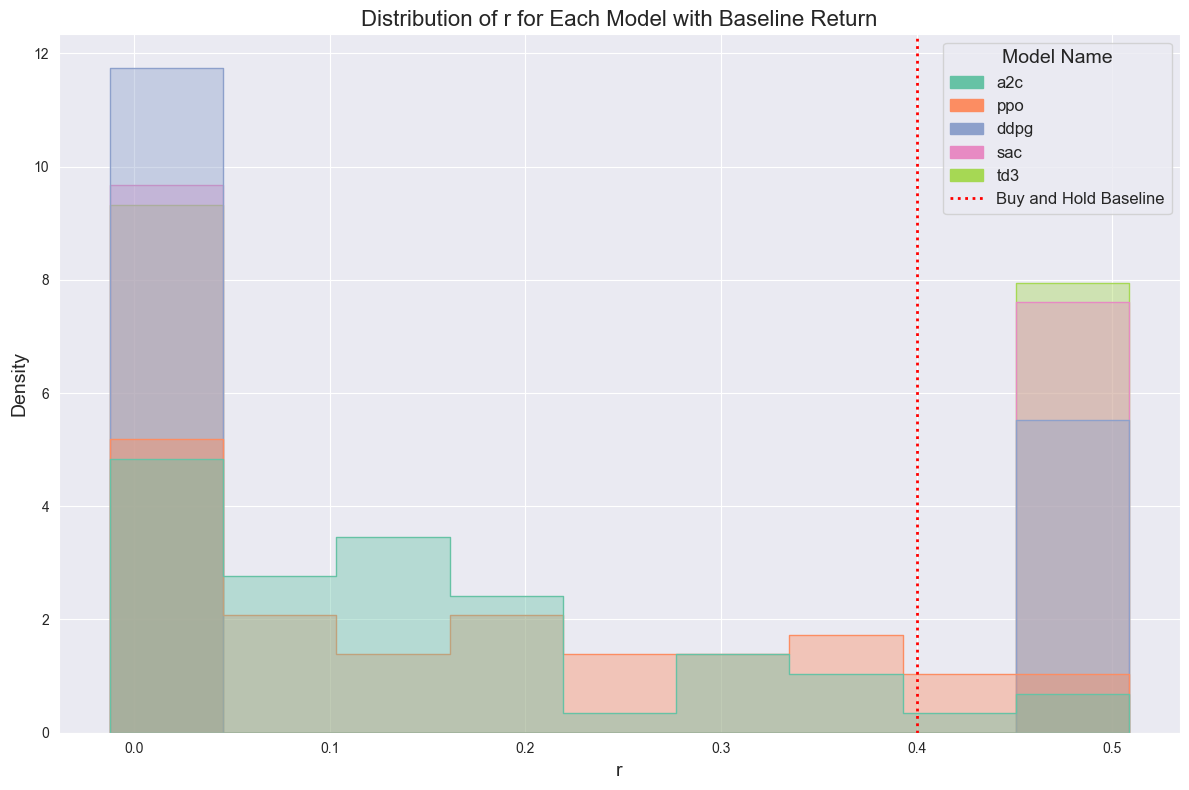

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
# Sample DataFrame (Replace this with your actual data)
import pandas as pd
import numpy as np
%matplotlib inline

# Define the baseline return
baseline_return = 0.40  # Adjust based on your actual baseline

# Initialize the plot
plt.figure(figsize=(12, 8))

# Plot the distribution with Seaborn's histplot
ax = sns.histplot(
    data=performance_stats,
    x='r',
    hue='model_name',
    kde=False,
    element='step',
    stat='density',
    common_norm=False,
    alpha=0.4,  # Increased alpha for better visibility
    palette='Set2',
    legend=False  # Disable automatic legend for manual control
)

# Add red vertical dotted line for baseline return
baseline_line = plt.axvline(
    x=baseline_return,
    color='red',
    linestyle='dotted',
    linewidth=2,
    label='Buy and Hold Baseline'
)

# Create custom legend handles for models
model_names = performance_stats['model_name'].unique()
model_colors = sns.color_palette('Set2', n_colors=len(model_names))
model_patches = [Patch(color=model_colors[i], label=model_names[i]) for i in range(len(model_names))]

# Create a custom legend handle for the baseline
baseline_handle = Line2D([0], [0], color='red', linestyle='dotted', linewidth=2, label='Buy and Hold Baseline')

# Combine all legend handles
handles = model_patches + [baseline_handle]
labels = [patch.get_label() for patch in model_patches] + [baseline_handle.get_label()]

# Add the combined legend to the plot
plt.legend(handles=handles, labels=labels, title='Model Name', fontsize=12, title_fontsize=14)

# Customize the plot
plt.title('Distribution of r for Each Model with Baseline Return', fontsize=16)
plt.xlabel('r', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.tight_layout()

# Display the plot
plt.show()

In [1]:
%load_ext tensorboard



In [2]:
%tensorboard --logdir tensorboard_log/


Reusing TensorBoard on port 6006 (pid 49484), started 0:00:23 ago. (Use '!kill 49484' to kill it.)

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [54]:
rebalance_window = 100
validation_window = 300


In [55]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [56]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

FileNotFoundError: [Errno 2] No such file or directory: 'results/account_value_trade_ensemble_400.csv'

In [17]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1000000.000000,2024-01-26,NaN,2024-01-26
1,999948.581878,2024-01-29,-0.000051,2024-01-29
2,999936.210695,2024-01-30,-0.000012,2024-01-30
3,999601.844153,2024-01-31,-0.000334,2024-01-31
4,999829.587885,2024-02-01,0.000228,2024-02-01


In [69]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
# Convert the date column to datetime format
#df_account_value['date'] = pd.to_datetime(df_account_value['date'])

# Set the date column as the index
#df_account_value.set_index('date', inplace=True)

# Visualization 1: Line plot for account value over time, with weekly xticks
plt.figure(figsize=(12, 6))
plt.plot(df_account_value.index, df_account_value['account_value'], marker='o', color='b')
plt.title('Account Value Over Time')
plt.xlabel('Date')
plt.ylabel('Account Value')

# Set xticks to display weekly intervals
plt.xticks(pd.date_range(start=df_account_value.index.min(), end=df_account_value.index.max(), freq='W'))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'df_account_value' is not defined

<Figure size 1200x600 with 0 Axes>

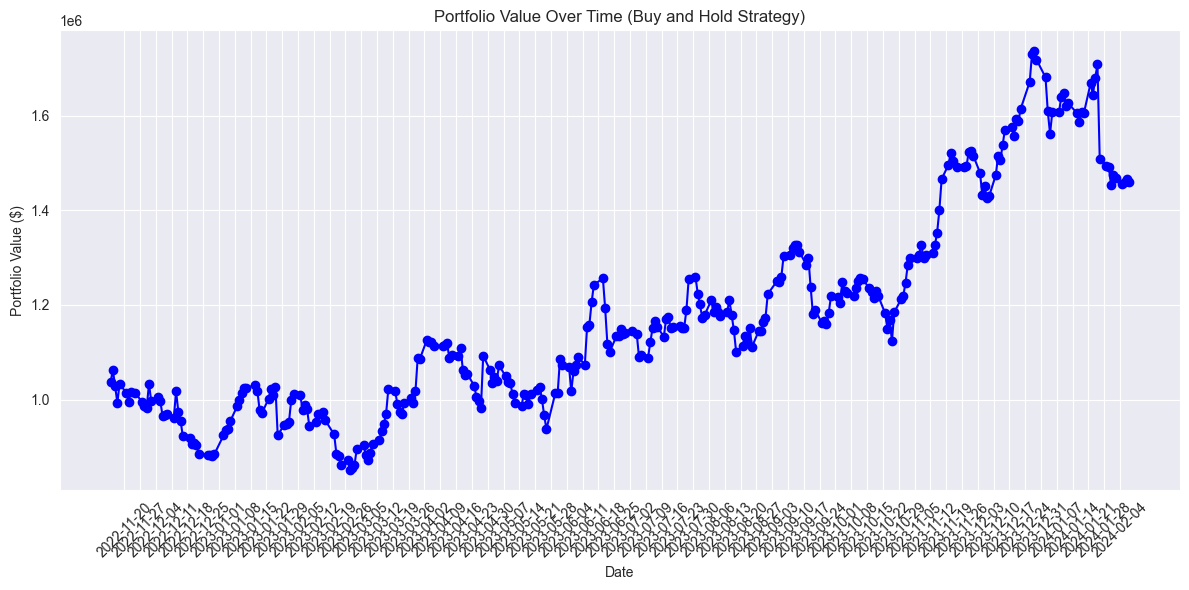

Annual return          0.320718
Cumulative returns     0.408042
Annual volatility      0.403973
Sharpe ratio           0.892573
Calmar ratio           1.619210
Stability              0.819204
Max drawdown          -0.198071
Omega ratio            1.167261
Sortino ratio          1.330988
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.144855
Daily value at risk   -0.049465
dtype: float64


In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the processed dataframe
portfolio_data = processed.copy()

# Ensure the date column is in datetime format in the copied dataframe
portfolio_data['date'] = pd.to_datetime(portfolio_data['date'])

# Set the initial investment amount
initial_investment = 1_000_000

# Define the start and end dates for the analysis
start_date = pd.to_datetime('2022-11-14')
end_date = pd.to_datetime('2024-02-08')

# Filter the dataframe for the starting date to get initial prices
initial_prices = portfolio_data[portfolio_data['date'] == start_date].copy()

# Calculate the number of shares purchased for each stock
initial_prices['shares'] = initial_investment / len(initial_prices) / initial_prices['open']

# Merge the number of shares into the copied dataframe
portfolio_data = portfolio_data.merge(initial_prices[['tic', 'shares']], on='tic', how='inner')

# Calculate the daily portfolio value
portfolio_data['daily_value'] = portfolio_data['close'] * portfolio_data['shares']
df_account_value_buynhold = portfolio_data.groupby('date')['daily_value'].sum().reset_index()
df_account_value_buynhold.rename(columns={'daily_value': 'account_value'}, inplace=True)

# Filter the data between the start_date and end_date
df_account_value_buynhold['date'] = pd.to_datetime(df_account_value_buynhold['date'])
df_account_value_buynhold = df_account_value_buynhold[
    (df_account_value_buynhold['date'] >= start_date) & (df_account_value_buynhold['date'] <= end_date)
]

# Set the date column as the index
df_account_value_buynhold.set_index('date', inplace=True)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(df_account_value_buynhold.index, df_account_value_buynhold['account_value'], marker='o', color='b')
plt.title('Portfolio Value Over Time (Buy and Hold Strategy)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')

# Set xticks to display weekly intervals
plt.xticks(pd.date_range(start=df_account_value_buynhold.index.min(),
                         end=df_account_value_buynhold.index.max(), freq='W'))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
df_account_value_buynhold['datadate'] = list(df_account_value_buynhold.index)
df_account_value_buynhold['date'] = list(df_account_value_buynhold.index)
perf_stats_all = backtest_stats(account_value=df_account_value_buynhold)
perf_stats_all = pd.DataFrame(perf_stats_all)



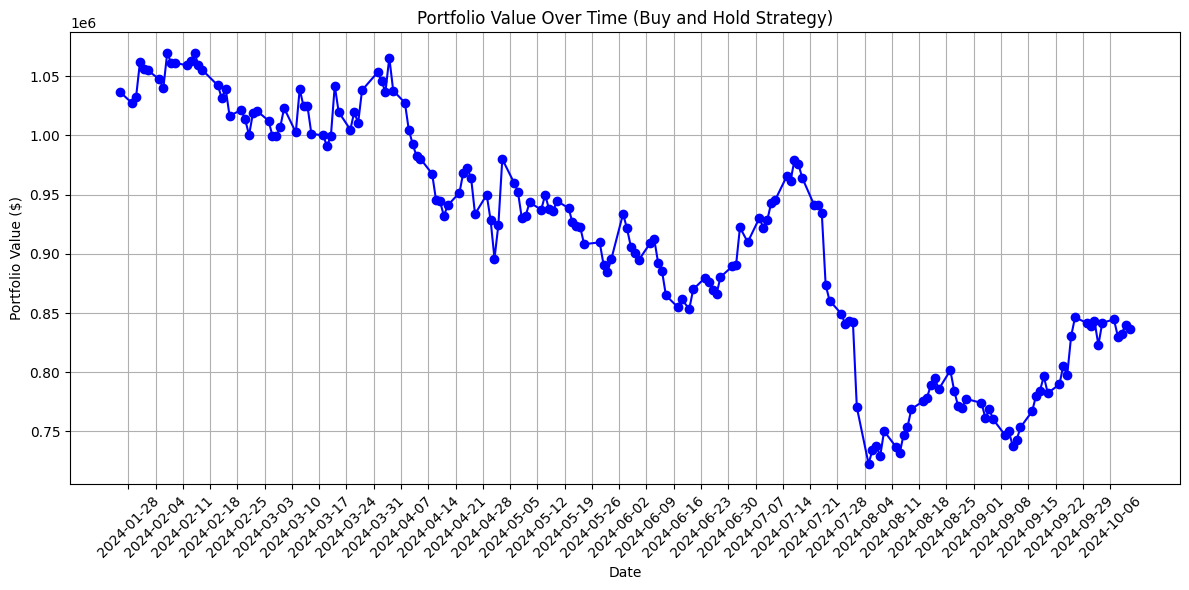

Annual return         -0.259010
Cumulative returns    -0.192749
Annual volatility      0.291997
Sharpe ratio          -0.885534
Calmar ratio          -0.798794
Stability              0.786265
Max drawdown          -0.324251
Omega ratio            0.861795
Sortino ratio         -1.190751
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.232643
Daily value at risk   -0.037814
dtype: float64


In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the processed dataframe
portfolio_data = processed.copy()

# Ensure the date column is in datetime format in the copied dataframe
portfolio_data['date'] = pd.to_datetime(portfolio_data['date'])

# Set the initial investment amount
initial_investment = 1_000_000

# Define the start and end dates for the analysis
start_date = pd.to_datetime('2024-01-26')
end_date = pd.to_datetime('2024-10-11')

# Filter the dataframe for the starting date to get initial prices
initial_prices = portfolio_data[portfolio_data['date'] == start_date].copy()

# Calculate the number of shares purchased for each stock
initial_prices['shares'] = initial_investment / len(initial_prices) / initial_prices['open']

# Merge the number of shares into the copied dataframe
portfolio_data = portfolio_data.merge(initial_prices[['tic', 'shares']], on='tic', how='inner')

# Calculate the daily portfolio value
portfolio_data['daily_value'] = portfolio_data['close'] * portfolio_data['shares']
df_account_value_buynhold = portfolio_data.groupby('date')['daily_value'].sum().reset_index()
df_account_value_buynhold.rename(columns={'daily_value': 'account_value'}, inplace=True)

# Filter the data between the start_date and end_date
df_account_value_buynhold['date'] = pd.to_datetime(df_account_value_buynhold['date'])
df_account_value_buynhold = df_account_value_buynhold[
    (df_account_value_buynhold['date'] >= start_date) & (df_account_value_buynhold['date'] <= end_date)
]

# Set the date column as the index
df_account_value_buynhold.set_index('date', inplace=True)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(df_account_value_buynhold.index, df_account_value_buynhold['account_value'], marker='o', color='b')
plt.title('Portfolio Value Over Time (Buy and Hold Strategy)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')

# Set xticks to display weekly intervals
plt.xticks(pd.date_range(start=df_account_value_buynhold.index.min(),
                         end=df_account_value_buynhold.index.max(), freq='W'))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
df_account_value_buynhold['datadate'] = list(df_account_value_buynhold.index)
df_account_value_buynhold['date'] = list(df_account_value_buynhold.index)
perf_stats_all = backtest_stats(account_value=df_account_value_buynhold)
perf_stats_all = pd.DataFrame(perf_stats_all)



<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
df_account_value = df_account_value.reset_index()

In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

In [ ]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')


<a id='6.2'></a>
## 7.2 BackTestPlot

In [ ]:


# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value,
#               baseline_ticker = '^DJI',
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();